In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.layers import Input, Dense, Conv2D, Flatten
from keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])        
    return X

### Data Load
- 'PL04496-03040' (prod_list[0]) 제품만을 대상으로
- 정상 데이터만으로 학습
- 전체 데이터로 테스트

In [3]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')
prod_list = isee_machine.ProductNum.unique()

# prod_list[0] 제품에 대해서만 분석
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]    

analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 
isee_machine['NG_Label'] = isee_machine['NG'] + isee_machine['NG5']
#isee_machine['3combined_label'] = isee_machine['K_mahala_label']+isee_machine['gmm_label']+isee_machine['IF_label']

- prop: 이상 비율 설정 (0.05876542354082906)

In [4]:
prop = isee_machine['NG'].sum()/len(isee_machine)

- 이상치 중 정상 추가

In [5]:
idx_labeled4 = isee_machine[isee_machine['combined_label']>=1].index.tolist()

for n in [40]:
    proba = []

    for id in idx_labeled4:
        temp_df_before = isee_machine.loc[id-n:id-1].sort_index(ascending=True).reset_index(drop=True)
        temp_df_after = isee_machine.loc[id+10:id+n-1+10].sort_index(ascending=False).reset_index(drop=True)
        proba.append((temp_df_before['NG'] * temp_df_before.index/n).sum() + (temp_df_after['NG'] * temp_df_after.index/n).sum())
        #proba.append((temp_df_after['NG'] * temp_df_after.index/n).sum())


    prob_df = pd.concat([pd.DataFrame(idx_labeled4, columns=['idx']),pd.DataFrame(proba, columns=['proba'])],axis=1)
    id_list = prob_df[prob_df.proba == 0]['idx'].values
    print("정상추가갯수: ", isee_machine.loc[id_list].groupby('combined_label')['combined_label'].count())
    isee_machine.loc[id_list,'combined_label'] = isee_machine.loc[id_list,'combined_label'] -1
    #isee_machine.set_value(prob_df[prob_df.proba == 0]['idx'].values,'combined_label', 0)

isee_machine['combined_label'].mask(isee_machine['combined_label']< 0, 0, inplace=True)

정상추가갯수:  combined_label
1    1266
2     477
3     742
4     317
5      36
Name: combined_label, dtype: int64


-  정상치 중 이상 제외

In [6]:
idx_labeled0 = isee_machine[isee_machine['combined_label']< 5].index.tolist()

n = 40
proba = []

for id in idx_labeled0:
    #proba.append(isee_machine.loc[id:id+n-1]['NG'].sum())
    temp_df_before = isee_machine.loc[id-n:id-1].sort_index(ascending=True).reset_index(drop=True)
    temp_df_after = isee_machine.loc[id+10:id+n-1+10].sort_index(ascending=False).reset_index(drop=True)
    proba.append((temp_df_before['NG'] * temp_df_before.index/n).sum() + (temp_df_after['NG'] * temp_df_after.index/n).sum())
    #proba.append((temp_df_after['NG'] * temp_df_after.index/n).sum())

prob_df = pd.concat([pd.DataFrame(idx_labeled0, columns=['idx']),pd.DataFrame(proba, columns=['proba'])],axis=1)

print("평균:, ",prob_df.proba.mean(), " max: ",prob_df.proba.max())
print("전체 정상 갯수: ", len(prob_df[prob_df.proba == 0]['idx']))

평균:,  2.291198521372417  max:  28.65
전체 정상 갯수:  19147


In [7]:
div = (prob_df.proba.max() - prob_df.proba.mean() * 3 ) /5

t1 = prob_df.proba.max() - div * 5
t2 = prob_df.proba.max() - div * 4
t3 = prob_df.proba.max() - div * 3
t4 = prob_df.proba.max() - div * 2
t5 = prob_df.proba.max() - div

#print(len(prob_df[(prob_df.proba > 0) & (prob_df.proba < 5)]['idx']))
print(len(prob_df[(t1 <= prob_df.proba) & (prob_df.proba < t2)]['idx']))
print(len(prob_df[(t2 <= prob_df.proba) & (prob_df.proba < t3)]['idx']))
print(len(prob_df[(t3 <= prob_df.proba) & (prob_df.proba < t4)]['idx']))
print(len(prob_df[(t4 <= prob_df.proba) & (prob_df.proba < t5)]['idx']))
print(len(prob_df[t5 <= prob_df.proba]['idx']))

3487
1489
677
154
86


In [8]:
isee_machine.set_value(prob_df[prob_df.proba >= t1]['idx'].values,'combined_label', 1)
isee_machine.set_value(prob_df[prob_df.proba >= t2]['idx'].values,'combined_label', 2)
isee_machine.set_value(prob_df[prob_df.proba >= t3]['idx'].values,'combined_label', 3)
isee_machine.set_value(prob_df[prob_df.proba >= t4]['idx'].values,'combined_label', 4)
isee_machine.set_value(prob_df[prob_df.proba >= t5]['idx'].values,'combined_label', 5)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.pat

,creationTime,ModuleCount,CycleTime,VpPosition,VpTime,VpPressure,MaxInjectionPressure,InjectionEndPosition,PlasticizingTime,PlasticsEndPosotion,...,NG5,ProductNum,K_mahala_label,mahala_label,lof_label,gmm_label,IF_label,svm_label,combined_label,NG_Label
0,2018-09-01 19:13:00,270172.0,42.120,25.0,4.9900,60.0,80.0,22.90,13.0900,97.200,...,0,PL04496-03040,0,0,1,1,1,1,2,0
1,2018-09-01 19:14:00,270173.5,42.110,25.0,5.0050,61.0,81.5,16.10,13.1500,97.250,...,0,PL04496-03040,0,0,0,1,0,1,0,0
2,2018-09-01 19:15:00,270175.0,42.110,25.0,4.9600,61.0,82.0,15.10,13.7300,97.200,...,0,PL04496-03040,0,0,0,1,0,1,0,0
3,2018-09-01 19:16:00,270176.0,42.110,25.0,4.9700,61.0,82.0,14.00,14.1600,97.100,...,0,PL04496-03040,0,0,0,1,0,1,0,0
4,2018-09-01 19:17:00,270177.5,42.110,25.0,4.9450,62.5,83.5,16.30,14.4100,97.150,...,0,PL04496-03040,0,0,0,1,0,1,0,0
5,2018-09-01 19:18:00,270179.0,42.110,25.0,4.7900,61.0,83.0,12.70,15.7500,96.800,...,0,PL04496-03040,0,0,0,1,1,1,1,0
6,2018-09-01 19:19:00,270180.5,42.105,25.0,4.9300,62.5,84.0,16.60,15.2900,97.050,...,0,PL04496-03040,0,0,0,1,0,1,0,0
7,2018-09-01 19:20:00,270182.0,42.100,25.0,4.8000,62.0,84.0,16.30,15.0100,96.900,...,0,PL04496-03040,0,0,0,1,0,1,0,0
8,2018-09-01 19:21:00,270183.5,42.100,25.0,4.8300,62.5,71.5,19.95,14.8800,96.900,...,0,PL04496-03040,0,0,0,1,1,1,1,0
9,2018-09-01 19:22:00,270185.0,42.100,25.0,4.9000,61.0,84.0,16.10,14.1100,97.100,...,0,PL04496-03040,0,0,0,1,0,1,0,0


- input 데이터 셋 생성

In [9]:
w=60    # window size
s=2     # stride
n= 30    # 몇분 후랑 복원율 비교?

X = []
Xf = []
label = []
labelf = []

target_label = 'combined_label'

for c in isee_machine['CycleNum'].unique():
    df = isee_machine[isee_machine['CycleNum']==c]
    df = df.reset_index(drop=True)
    for i in range(int((len(df)-w)/s - n)):
        t_df_before = df.loc[s*i:s*i+w-1]
        t_sum_before = int((t_df_before[target_label]).max())
        
        t_df_after = df.loc[s*i+n:s*i+w-1+n]
        t_sum_after = int((t_df_after[target_label]).max()) 

        X.append(t_df_before[analy_col].values)
        label.append(t_sum_before)
        
        Xf.append(t_df_after[analy_col].values)
        labelf.append(t_sum_after)

X = np.array(X)
Xf = np.array(Xf)        
print(np.unique(label))

[0 1 2 3 4 5]


In [10]:
label_df = pd.concat([pd.DataFrame(label, columns=['label0']),pd.DataFrame(labelf, columns=['label1'])], axis=1)
normal_idx = label_df[(label_df.label0==0) & (label_df.label1==0)].index.tolist()
test_idx = label_df[(label_df.label0==0)].index.tolist()

X_train = X[normal_idx]
X_future = Xf[normal_idx]

X_test = X[test_idx]
X_future_test = Xf[test_idx]

print("정상 데이터 수: ",len(normal_idx), " 전체 데이터 수 :", len(label_df))

정상 데이터 수:  7140  전체 데이터 수 : 25898


In [11]:
prop = 1 - (len(normal_idx) / len(test_idx))
prop

0.20798668885191351

- scale

In [12]:
# 정상 데이터로만 scale
# Initialize a scaler using the training data.
scaler = MinMaxScaler().fit(np.concatenate((flatten(X_train),flatten(X_future)),axis=0))

scaled_train = scale(X_train, scaler)
scaled_future = scale(X_future, scaler)

# 전체 데이터로 테스트
scaled_X = scale(X_test, scaler)
scaled_Xf = scale(X_future_test, scaler)

In [13]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout, RepeatVector
from keras.utils import plot_model

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

input_data = Input(shape=X_train.shape[1:])
x = LSTM(units=8, activation='relu', input_shape = (timesteps, n_features), return_sequences=True)(input_data)
x = LSTM(units=4, activation='relu', return_sequences=True)(x)
#x = RepeatVector(timesteps)(x)

x = LSTM(units=4, activation='relu', return_sequences=True)(x)
x = LSTM(units=8, activation='relu', return_sequences=True)(x)
decoded = TimeDistributed(Dense(units=n_features))(x)

autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

### fit model
autoencoder.fit(scaled_train, scaled_future, epochs= 5, batch_size=128, shuffle=True, verbose=1)
autoencoder.summary()
#plot_model(autoencoder, show_shapes=True)  # , to_file='reconstruct_lstm_autoencoder.png'

Epoch 1/5
7140/7140 [==============================] - 9s 1ms/step - loss: 0.2691
Epoch 2/5
7140/7140 [==============================] - 6s 900us/step - loss: 0.1669
Epoch 3/5
7140/7140 [==============================] - 6s 875us/step - loss: 0.1082
Epoch 4/5
7140/7140 [==============================] - 6s 854us/step - loss: 0.0855
Epoch 5/5
7140/7140 [==============================] - 6s 897us/step - loss: 0.0770
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 17)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 8)             832       
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 4)             208       
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 4)            

In [14]:
# demonstrate recreation
lstm_predict = autoencoder.predict(scaled_X)

In [15]:
lstm_predict = lstm_predict.reshape(lstm_predict.shape[0], lstm_predict.shape[1]* lstm_predict.shape[2])
X2 = scaled_Xf.reshape(scaled_Xf.shape[0], scaled_Xf.shape[1]* scaled_Xf.shape[2])

In [16]:
### calculate MSE
temp_df = pd.DataFrame(mean_squared_error(X2.T, lstm_predict.T, multioutput='raw_values'), columns=['mse'])

In [17]:
k = sorted(temp_df.mse.values, reverse=True)
t = np.ceil(len(temp_df.mse.values) * prop).astype(int)

lstmAE_label = []
for x in temp_df.mse.values:
    if x >= k[int(t/5*1)]: lstmAE_label.append(5)
    elif x < k[int(t/5*1)] and x >= k[int(t/5*2)]: lstmAE_label.append(4)
    elif x < k[int(t/5*2)] and x >= k[int(t/5*3)]: lstmAE_label.append(3)
    elif x < k[int(t/5*3)] and x >= k[int(t/5*4)]: lstmAE_label.append(2)
    elif x < k[int(t/5*4)] and x >= k[int(t/5*5)]: lstmAE_label.append(1)
    else: lstmAE_label.append(0)
    

temp_df['lstmAE_label'] = lstmAE_label
temp_df = pd.concat([temp_df,label_df.loc[test_idx].reset_index(drop=True)], axis=1)

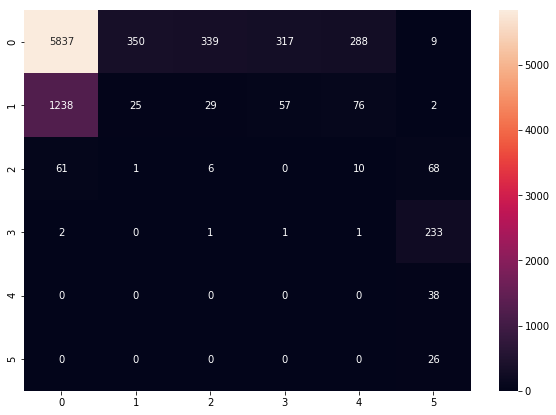

In [18]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

#y = [0 if x <2 else 1 for x in temp_df.next_label]
df_cm = pd.DataFrame(confusion_matrix(temp_df.label1, temp_df.lstmAE_label))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

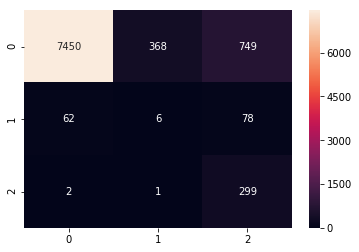

In [23]:
y = []
for x in temp_df.lstmAE_label:
    if x <2: y.append(0)
    elif x==2: y.append(1)
    else: y.append(2)
t = []
for x in temp_df.label1:
    if x <2:t.append(0)
    elif x==2: t.append(1)
    else: t.append(2)
        
df_cm = pd.DataFrame(confusion_matrix(t, y))
sn.heatmap(df_cm, annot=True, fmt='d')

In [19]:
print(classification_report(temp_df.label1, temp_df.lstmAE_label))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      7140
           1       0.07      0.02      0.03      1427
           2       0.02      0.04      0.02       146
           3       0.00      0.00      0.00       238
           4       0.00      0.00      0.00        38
           5       0.07      1.00      0.13        26

   micro avg       0.65      0.65      0.65      9015
   macro avg       0.16      0.31      0.17      9015
weighted avg       0.66      0.65      0.65      9015



In [20]:
temp_df.groupby(['label1'])[['mse']].describe().T

label1               0            1           2           3          4  \
mse count  7140.000000  1427.000000  146.000000  238.000000  38.000000   
    mean      0.074211     0.072898    0.377636    4.998838   5.694322   
    std       0.022374     0.020964    0.629816    9.161140   7.244777   
    min       0.027817     0.027902    0.044206    0.086091   0.529777   
    25%       0.063387     0.059903    0.070169    0.653406   0.531430   
    50%       0.067366     0.067642    0.112592    1.391089   1.945561   
    75%       0.098974     0.081626    0.545135    4.300402  11.167035   
    max       0.120742     0.222379    3.406212   47.975439  18.574745   

label1             5  
mse count  26.000000  
    mean   31.776849  
    std    38.068674  
    min     0.273705  
    25%     4.005075  
    50%     9.643731  
    75%    86.524217  
    max    87.534757

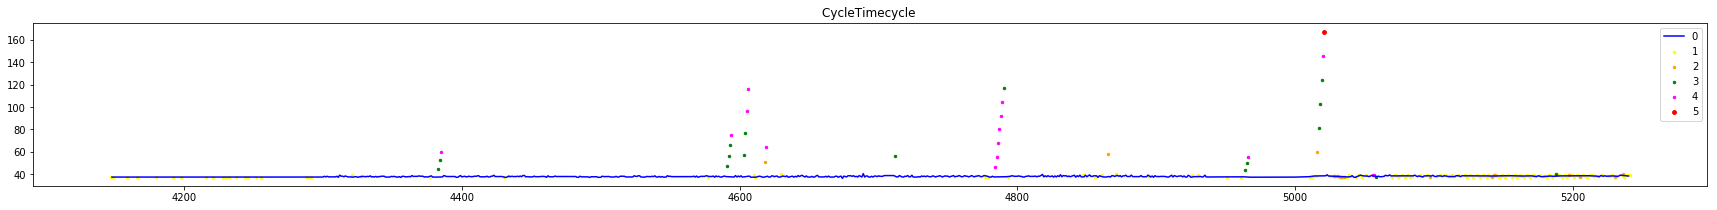

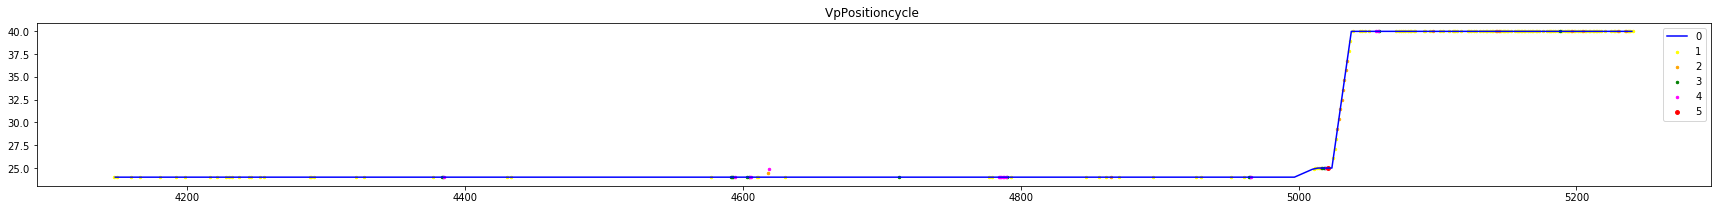

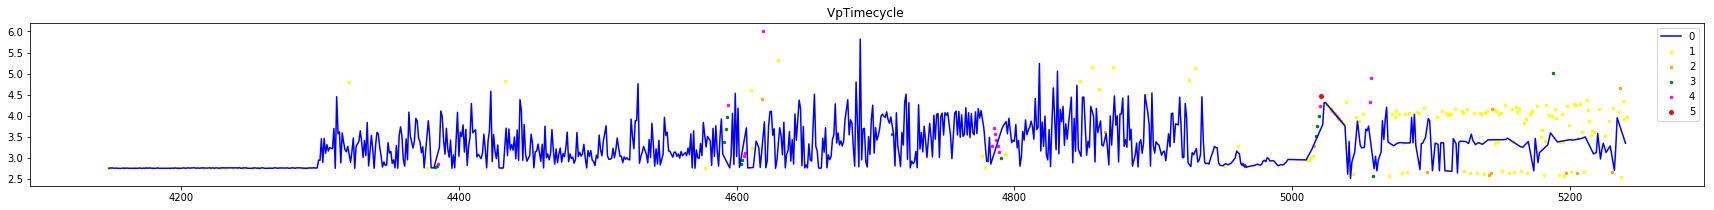

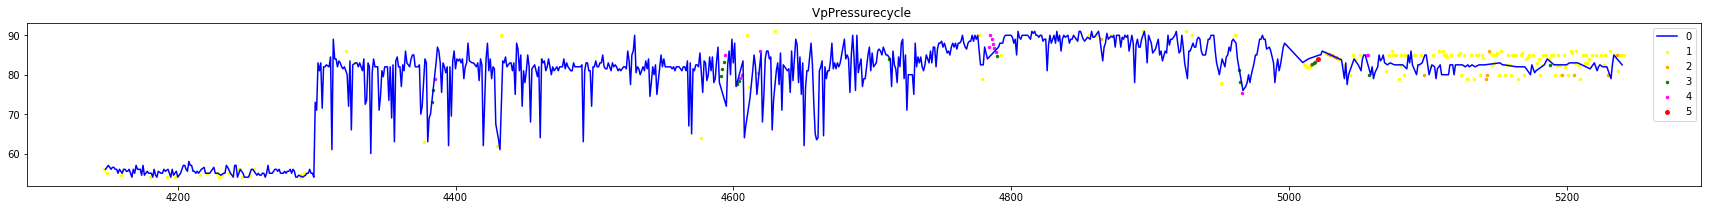

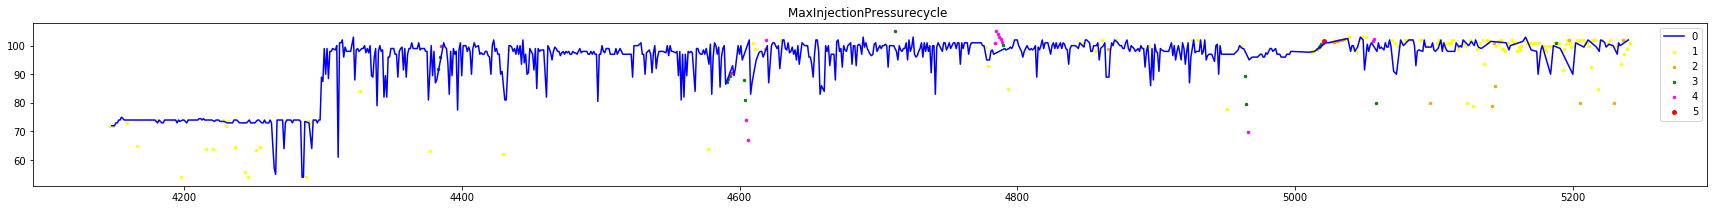

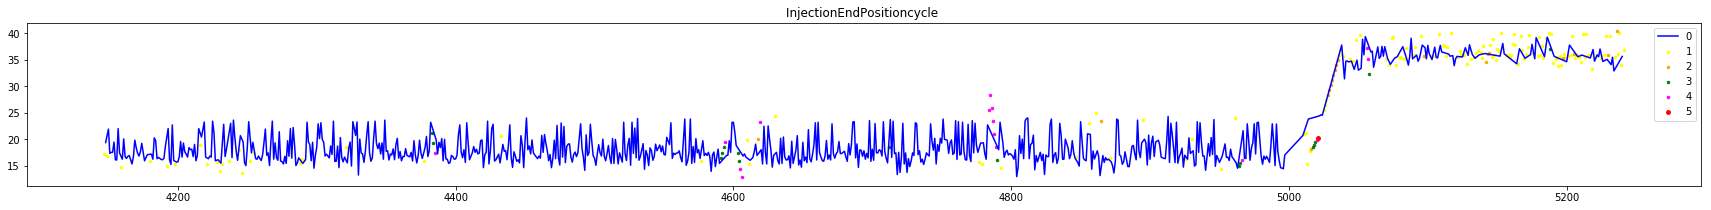

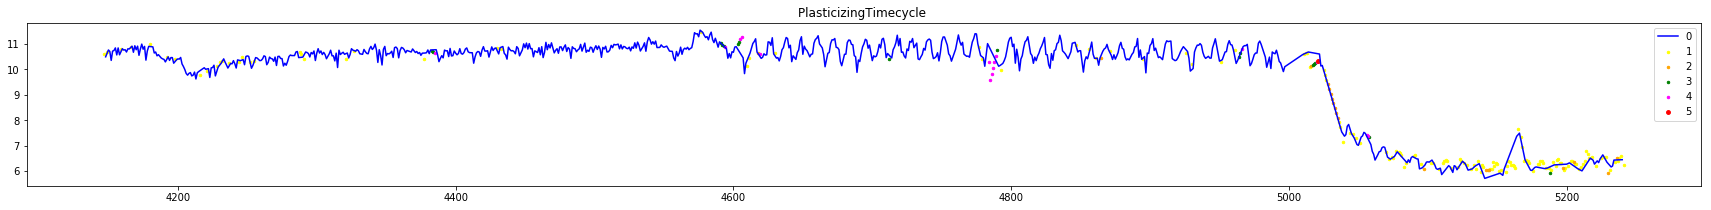

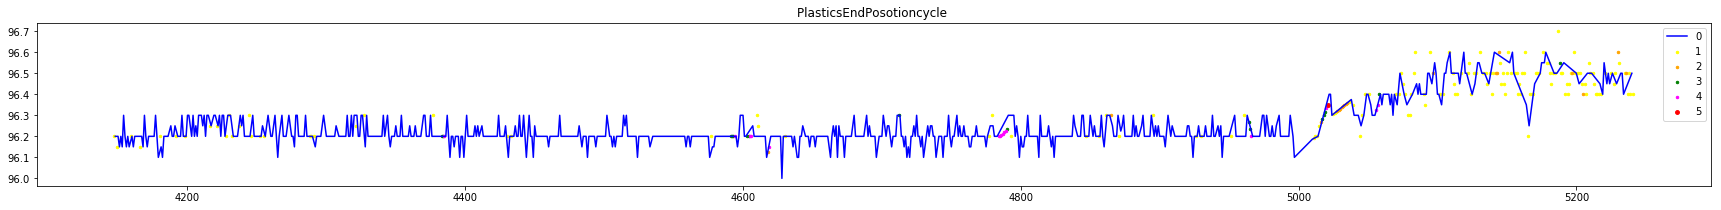

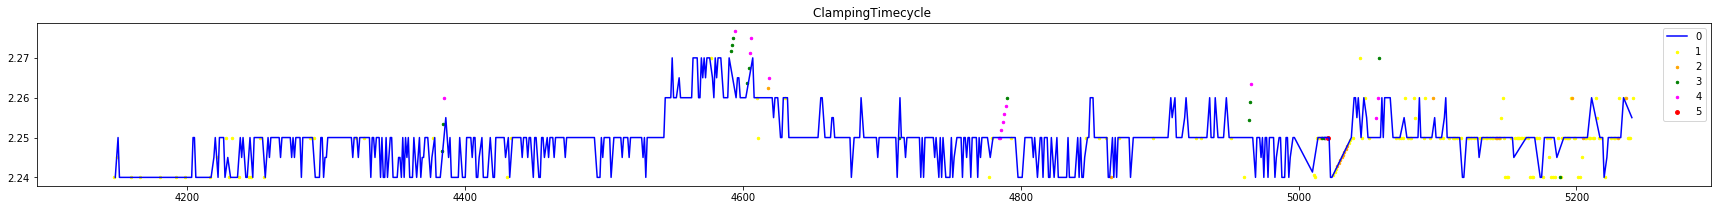

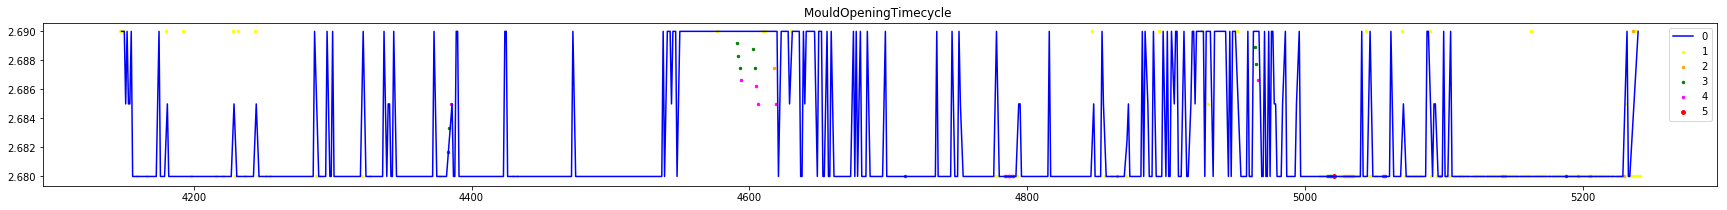

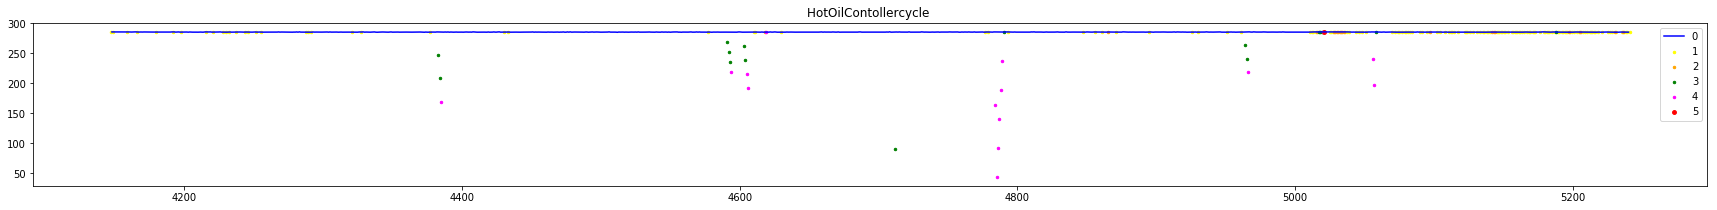

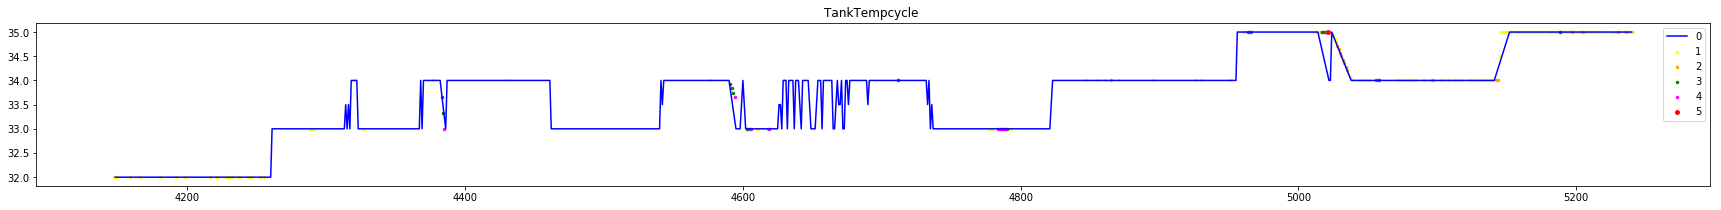

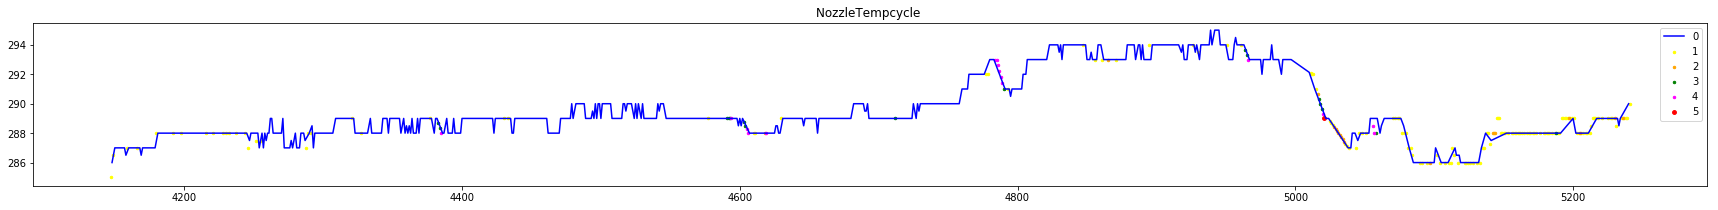

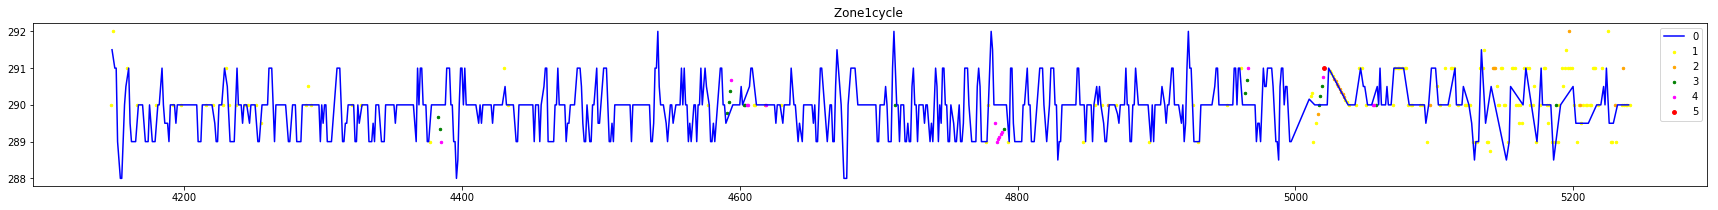

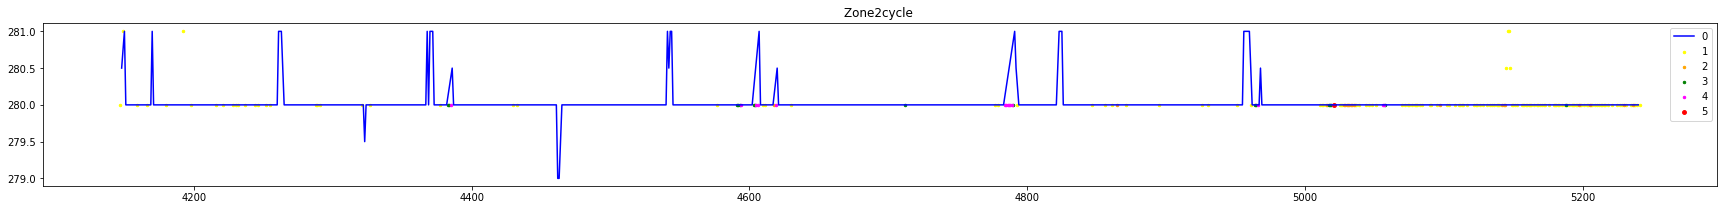

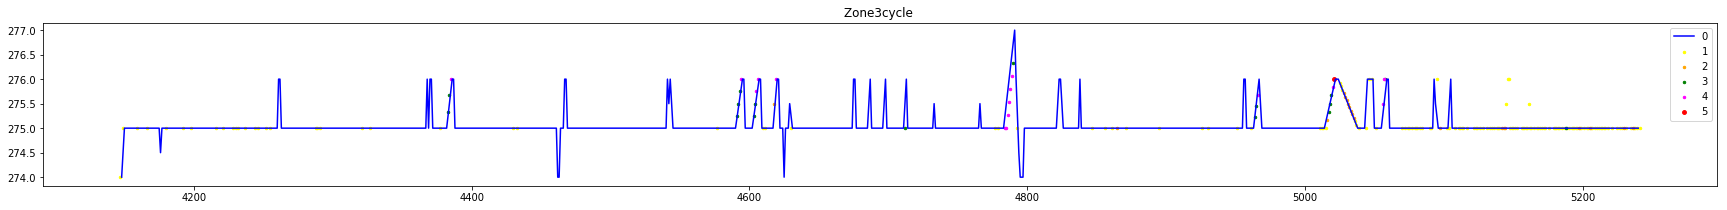

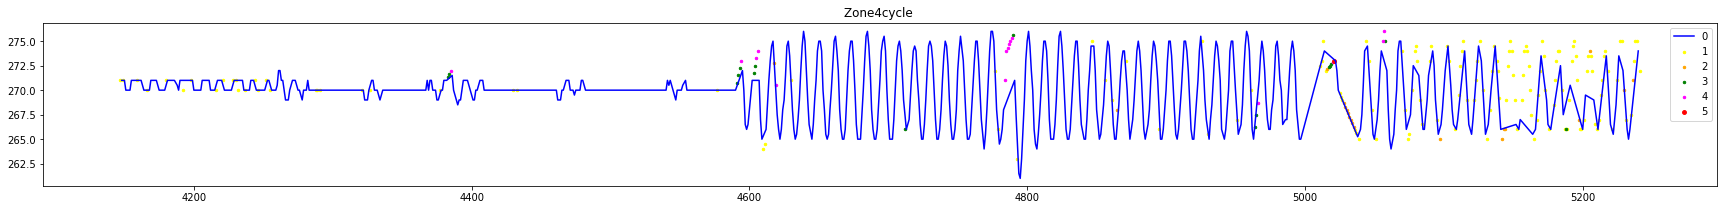

In [76]:
df_name = isee_machine[isee_machine.CycleNum==8]
NG_target = 'combined_label'
c_dic= {0:'blue', 1:'yellow', 2:'orange', 3:'green', 4:'magenta', 5:'red'}

for i in range(len(analy_col)):
    fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(30,3))
    for n in np.unique(df_name[NG_target]):
        if n == 0 :
            ax1.plot(df_name[df_name[NG_target]==n][analy_col[i]].index, df_name[df_name[NG_target]==n][analy_col[i]], c=c_dic[n], label=n,)
            ax1.legend()
            ax1.set_title(analy_col[i]+'cycle ') # + str(cycle_num)
        else:
            s=6
            if n == 5: s= 15    
            ax1.scatter(df_name[df_name[NG_target]==n][analy_col[i]].index, df_name[df_name[NG_target]==n][analy_col[i]], c=c_dic[n], label=n, s=s)
            ax1.legend()
            ax1.set_title(analy_col[i]+'cycle ') # + str(cycle_num)

### Option) One class SVM
One class SVM 학습에 combined_label 정상(0)을 사용하여, 나머지(1,2,3,4,5) 분류
- 목적: combined_label의 성능 테스트
- 결과: 3,4,5는 이상치가 확실한 듯

In [38]:
normal_df = isee_machine[isee_machine.combined_label==0]
t_scaler = StandardScaler().fit(normal_df[analy_col])

In [39]:
normal_scaled_X = t_scaler.transform(normal_df[analy_col])
scaled_total = t_scaler.transform(isee_machine[analy_col])

In [40]:
from sklearn import svm

clf = svm.OneClassSVM(nu=prop, kernel='rbf')
clf.fit(normal_scaled_X)

y_pred = clf.predict(scaled_total)

y_pred = [1 if x == -1 else 0 for x in y_pred]

In [41]:
df = pd.DataFrame(y_pred, columns=['svm_label'])

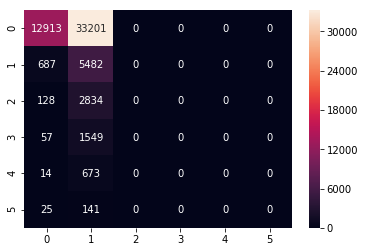

In [42]:
### plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(isee_machine['combined_label'], df['svm_label']))
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')

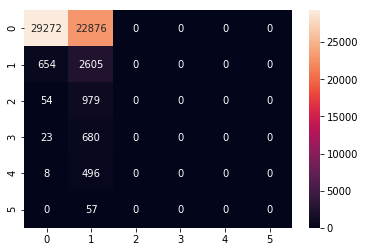

In [84]:
### plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(isee_machine['combined_label'], df['svm_label']))
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')

In [69]:
print(classification_report(isee_machine['combined_label'], df['svm_label']))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     48666
           1       0.27      0.53      0.36      4881
           2       0.00      0.00      0.00      1548
           3       0.00      0.00      0.00      1574
           4       0.00      0.00      0.00       916
           5       0.00      0.00      0.00       119

   micro avg       0.84      0.84      0.84     57704
   macro avg       0.20      0.25      0.22     57704
weighted avg       0.83      0.84      0.83     57704



C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
